In [1]:
import numpy as np # linear algebra
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import util 
from timeit import default_timer as timer
# set a results file
logger = util.result(path="", file="results.logs")
logger.propagate = False

from sklearn.preprocessing import StandardScaler

<h3 style="color: #dddda1">Pull configs and set defaults</h3>

In [2]:
files = util.get_config_values("files")
validation_types = util.get_config_values("validation_types")
split_types = util.get_config_values("split_types")

split_size = util.get_config_values("split_size")
preprocessors = util.get_config_values("preprocessors")
models = util.get_config_values("models")
evaluators = util.get_config_values("evaluators")
pls_max_n_comp = util.get_config_values("general", list_type=False, key="pls_max_n_comp")
folds = util.get_config_values("general", list_type=False, key="folds")
wl = np.arange(1100, 2252, 2) # Set wavelength range
pipeline_run_types = util.get_config_values("pipeline_run_types")

<h3 style="color: #eeaf23">Data Import, Split (85/15) and Visualization</h3>

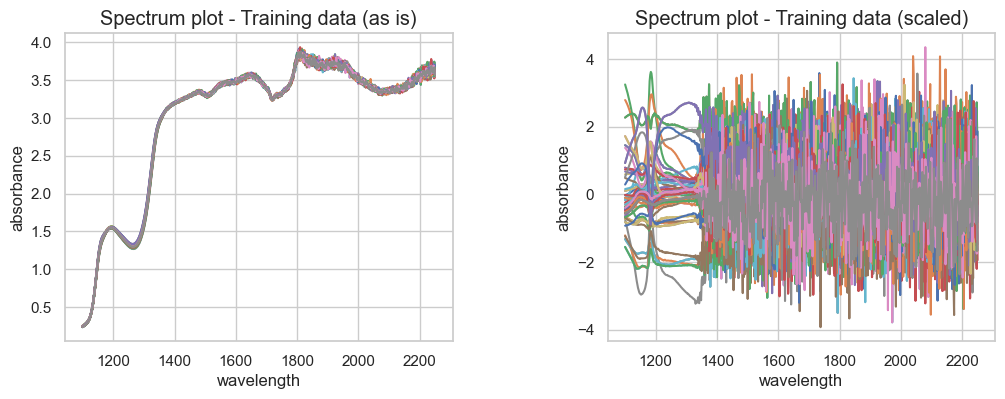

In [4]:
# for only one file - write dataset = files[index] (index maybe 0-3).
# For multiple files set value as list. e.g. - [files[0],files[2]]
# for all files, set dataset = files
dataset = files[1]   # using the beer dataset

# Nothing to change here.
split_params = {
    'sep' : ',',
    'drop_columns' : ['y'],
    'index_column' : None,
    'y_data_column' : 'y',
}

# Data splitting can be done in various proportions. Check proportions of train-test values available in configfile.ini file
data = (X_train, X_test, y_train, y_test) = util.get_split_data(files=dataset, split_params=split_params, test_size=float(split_size[0]), showDataEDA=False)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# plot training spectrum as is
# util.plot(x_axis_data=wl, y_axis_data=X_train, title='Spectrum plot - Training data (as is)', xlabel='wavelength',
#      ylabel='absorbance')

#
# util.plot(x_axis_data=wl, y_axis_data=X_train_scaled, title='Spectrum plot - Training data (scaled)', xlabel='wavelength',
#      ylabel='absorbance')

plot1_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train,
    'title':'Spectrum plot - Training data (as is)',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
plot2_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train_scaled,
    'title':'Spectrum plot - Training data (scaled)',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
util.dual_plot(plot1_params,plot2_params)

<h3 style="color: #00faaa">PIPELINE 1 [comparing SavGol results]</h3>
<h5 style="color: white">Preprocessor - SavGol (Derivative 0, 1, 2)</h5>
<h5 style="color: white">Train/Test split size (FIXED) - 80/20</h5>
<h5 style="color: white">Validation method (FIXED) - KFolds CV, folds=5</h5>

INFO ************************************
INFO Pipeline Start...
INFO Pipeline params :
INFO Data : data/beer_dataset.csv , Preprocessor : savgol0, Model : pls, Evaluator : mse
INFO Validation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]


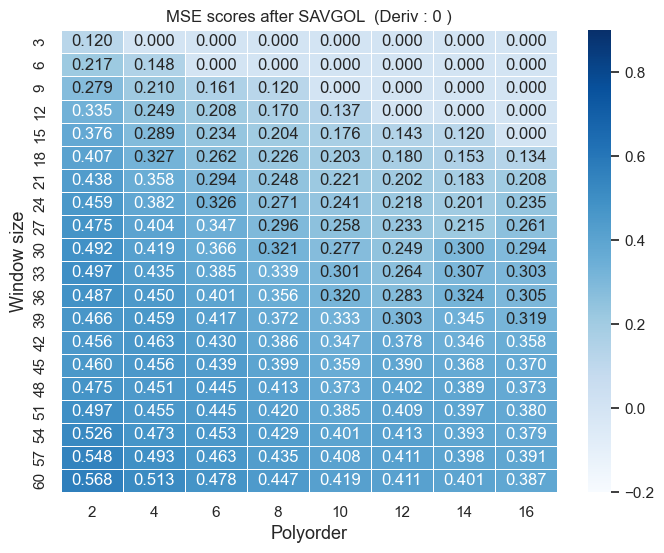

INFO Least MSE from SAVGOL loop run 0.12013527677502309
INFO Best window size 3
INFO Best polyorder 2


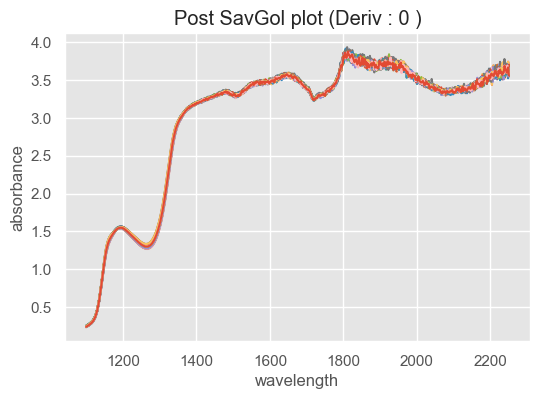

INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 



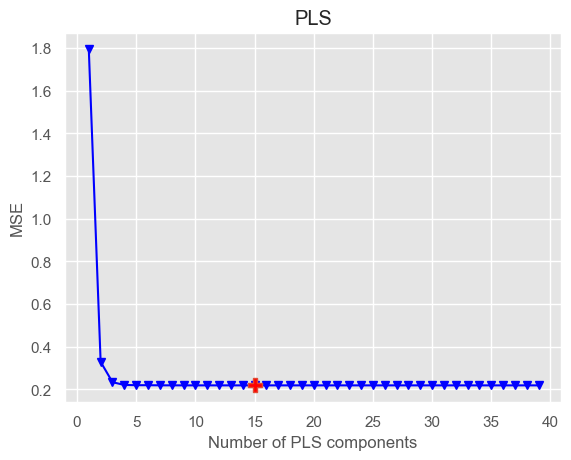

INFO Optimized n_comp for PLS 15
INFO [MODEL EVALUATION]


[Model Evaluation] MSE value between y_test and y_pred : 0.093


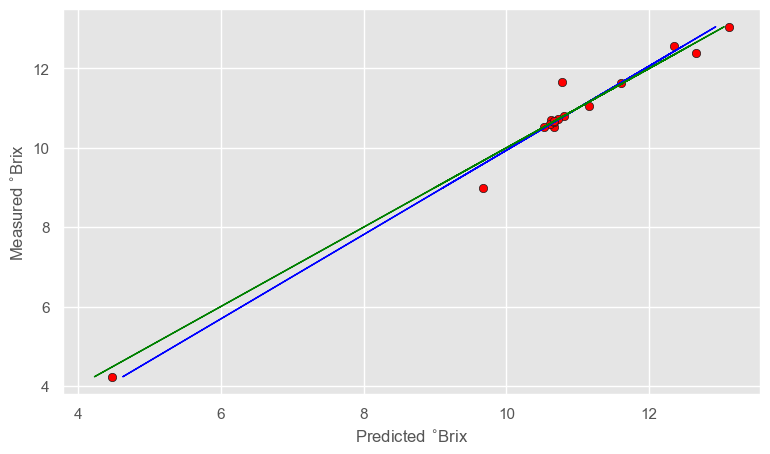

INFO Model loss : 0.09314116105352524
INFO Elapsed time for pipeline run : 3.88
INFO Pipeline end...
INFO ************************************
INFO ************************************
INFO Pipeline Start...
INFO Pipeline params :
INFO Data : data/beer_dataset.csv , Preprocessor : savgol1, Model : pls, Evaluator : mse
INFO Validation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]


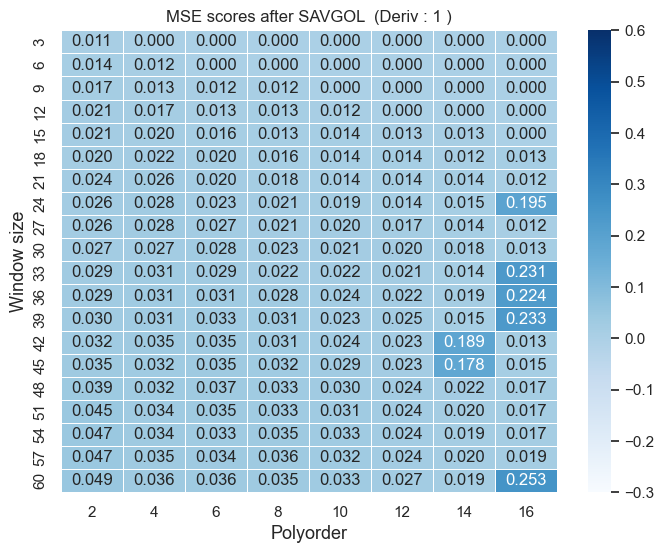

INFO Least MSE from SAVGOL loop run 0.011285997058215294
INFO Best window size 3
INFO Best polyorder 2


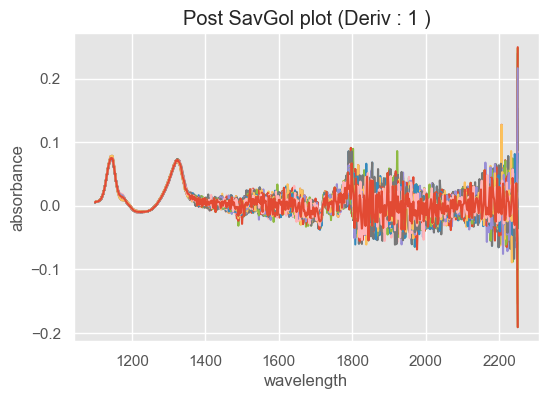

INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 



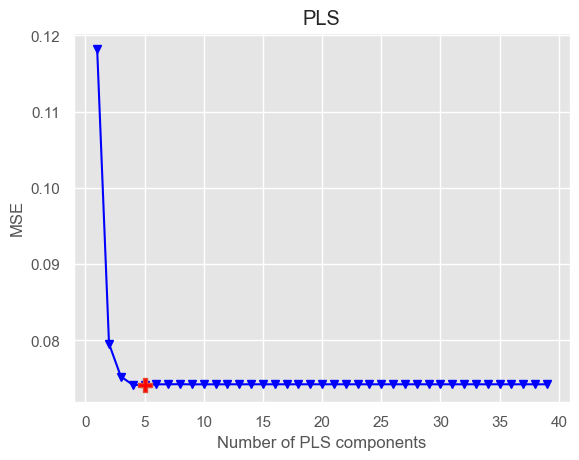

INFO Optimized n_comp for PLS 5
INFO [MODEL EVALUATION]


[Model Evaluation] MSE value between y_test and y_pred : 0.043


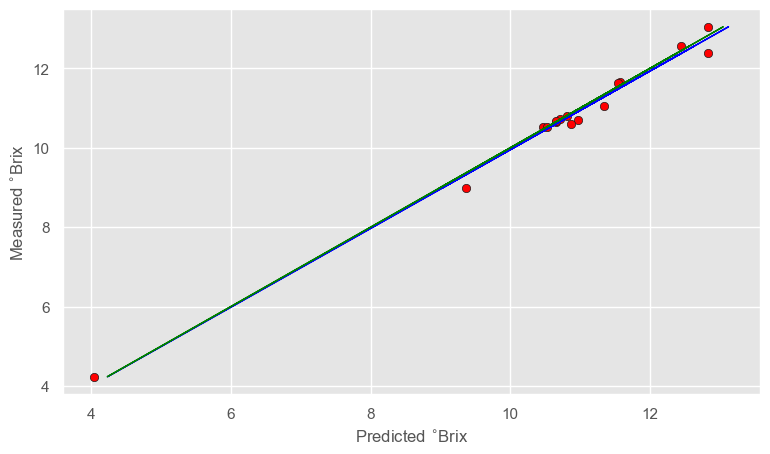

INFO Model loss : 0.04333294450494032
INFO Elapsed time for pipeline run : 2.96
INFO Pipeline end...
INFO ************************************
INFO ************************************
INFO Pipeline Start...
INFO Pipeline params :
INFO Data : data/beer_dataset.csv , Preprocessor : savgol2, Model : pls, Evaluator : mse
INFO Validation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]


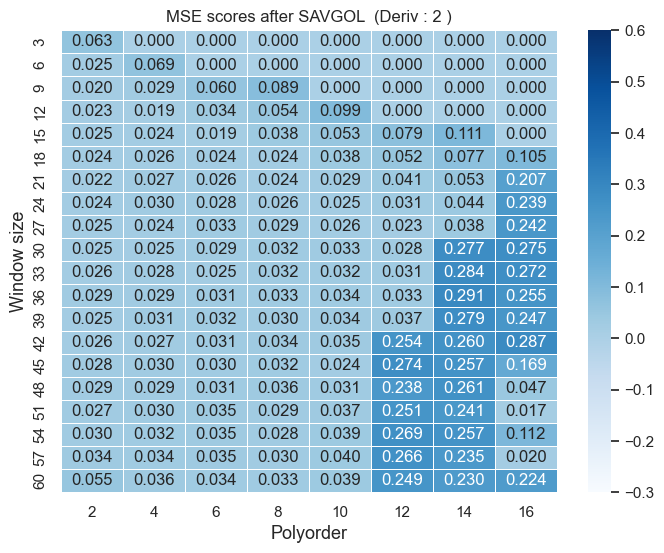

INFO Least MSE from SAVGOL loop run 0.016959467889935034
INFO Best window size 51
INFO Best polyorder 16


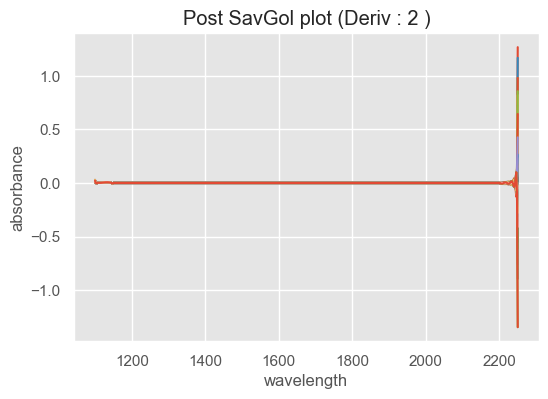

INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 



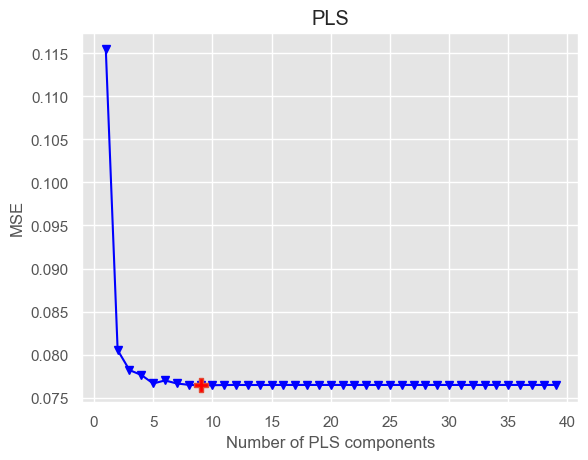

INFO Optimized n_comp for PLS 9
INFO [MODEL EVALUATION]


[Model Evaluation] MSE value between y_test and y_pred : 0.031


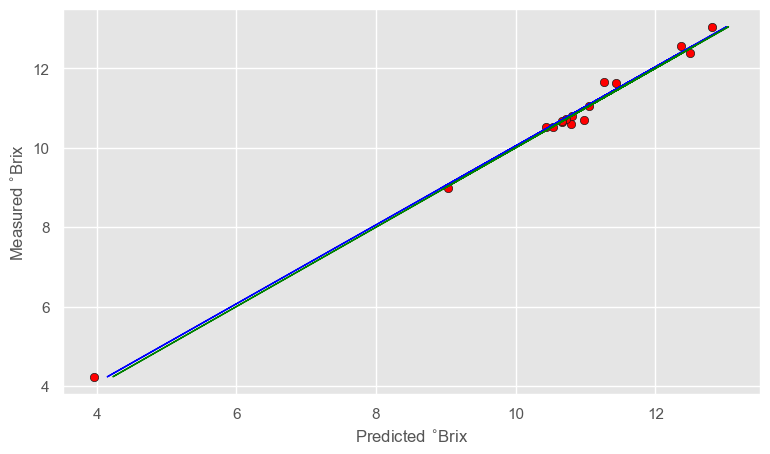

INFO Model loss : 0.03093757265160424
INFO Elapsed time for pipeline run : 3.03
INFO Pipeline end...
INFO ************************************


In [5]:
# Data splitting can be done in various proportions. Check proportions of train-test values available in configfile.ini file
data = (X_train, X_test, y_train, y_test) = util.get_split_data(files=dataset, split_params=split_params, test_size=float(split_size[1]), showDataEDA=False)

# Run pipeline in loop for all preprocessors combinations OR
# For selected preprocessors only, you can run the loop using a slice from the whole preprocessors list variable.
# To check which slice you want, check the configfile.ini file
for index, val in enumerate(preprocessors):
    if index in [0,1,2]:     # selecting only the required preprocessors

        # Ideally not required to change anything here.
        # But you can change the derivative explicitly as per your choice (0,1 or 2)
        preprocessor_params = {
            'savgol' : {
                'window_size_range' : np.arange(3,63,3),
                'polyorder_range' : np.arange(2,18,2),
                'derivative' : index
            }
        }

        # Set plotting:True for showing all plots (preprocessing, model fitting, etc. everything)
        # Set showModelEvaluationPlots:True specifically to show final model evaluation and line of best fit plots. IDEALLY MUST BE SET TO True
        # Set models[0] for PLS and models[1] for LASSO
        # evaluators[0] means MSE. Nothing to change here because MSE is best for regression model evaluation
        # preprocessor: preprocessor[index] where index is (0,...,10). Here since it's running in loop, it gets from val.
        # preprocessor-params: only required for SavGol and its related combos.
        # pipeline_run_type: pipeline_run_types[index] -> index can be 0 or 1. 0 means only until preprocessing, 1 means total.
        pipeline_params = {
            'logger' : logger,
            'data' : data,
            'validation-type' : validation_types[0],
            'preprocessor' : val,
            'preprocessor-params' : preprocessor_params,
            'model' : models[0],
            'evaluator' : evaluators[0],
            'pls_max_n_comp' : int(pls_max_n_comp),
            'folds' : int(folds),
            'wl' : wl,
            'plotting' : True,
            'showModelEvaluationPlots' : True,
            'pipeline_run_type' : pipeline_run_types[1]
        }

        start = timer()
        logger.info("************************************")
        logger.info("Pipeline Start...")
        logger.info("Pipeline params :")
        logger.info("Data : " + str(dataset) + " , Preprocessor : " + str(pipeline_params['preprocessor'])
                    + ", Model : " + str(pipeline_params['model']) + ", Evaluator : " + str(pipeline_params['evaluator']))
        logger.info("Validation type : " + str(pipeline_params['validation-type']) + ", PLS max n_comp : "
                    + str(pipeline_params['pls_max_n_comp']) + ", folds (for CV) : " + str(pipeline_params['folds']))
        util.pipeline(pipeline_params)
        end = timer()
        logger.info("Elapsed time for pipeline run : " + str(round((end - start),2)))
        logger.info("Pipeline end...")
        logger.info("************************************")

<h3 style="color: #00faaa">PIPELINE 2 (No Plots)</h3>
<h5 style="color: white">Preprocessor - All</h5>
<h5 style="color: white">Train/Test split size (Modifiable)</h5>
<h5 style="color: white">Validation method (FIXED) - KFolds CV, folds=5</h5>

INFO Pipeline Start...
INFO Parameters :
INFO Data : data/beer_dataset.csv , Preprocessor : savgol0, Model : pls, Evaluator : mse, Validation type : stratified-kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO Least MSE from SAVGOL loop run 0.13162111573424773
INFO Best window size 15
INFO Best polyorder 14
INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 

INFO Optimized n_comp for PLS 4
INFO [MODEL EVALUATION]




[Model Evaluation] MSE value between y_test and y_pred : 0.077


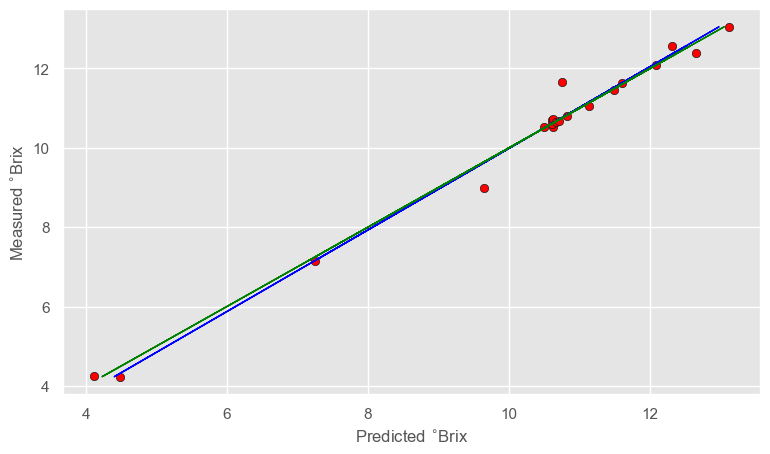

INFO Model loss : 0.07670725410313842
INFO Elapsed time for pipeline run : 3.11
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : data/beer_dataset.csv , Preprocessor : savgol1, Model : pls, Evaluator : mse, Validation type : stratified-kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO Least MSE from SAVGOL loop run 0.006600385040642968
INFO Best window size 18
INFO Best polyorder 14
INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 

INFO Optimized n_comp for PLS 3
INFO [MODEL EVALUATION]




[Model Evaluation] MSE value between y_test and y_pred : 0.047


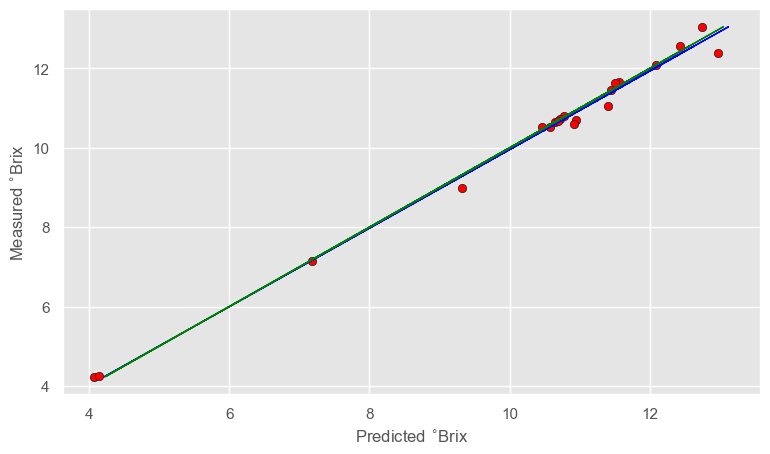

INFO Model loss : 0.04658682974822248
INFO Elapsed time for pipeline run : 3.08
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : data/beer_dataset.csv , Preprocessor : savgol2, Model : pls, Evaluator : mse, Validation type : stratified-kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO Least MSE from SAVGOL loop run 0.015797357807245047
INFO Best window size 15
INFO Best polyorder 6
INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 

INFO Optimized n_comp for PLS 6
INFO [MODEL EVALUATION]




[Model Evaluation] MSE value between y_test and y_pred : 0.039


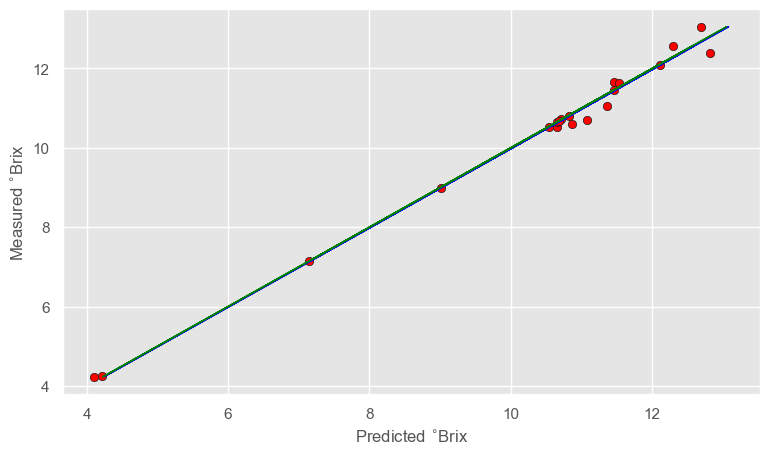

INFO Model loss : 0.03928925781875058
INFO Elapsed time for pipeline run : 2.41
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : data/beer_dataset.csv , Preprocessor : snv, Model : pls, Evaluator : mse, Validation type : stratified-kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 

INFO Optimized n_comp for PLS 3
INFO [MODEL EVALUATION]




[Model Evaluation] MSE value between y_test and y_pred : 0.020


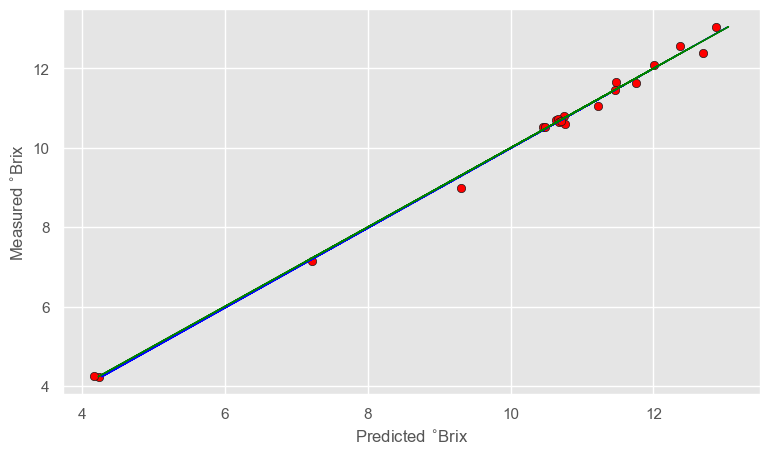

INFO Model loss : 0.02049062622643074
INFO Elapsed time for pipeline run : 2.0
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : data/beer_dataset.csv , Preprocessor : msc, Model : pls, Evaluator : mse, Validation type : stratified-kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 

INFO Optimized n_comp for PLS 3
INFO [MODEL EVALUATION]




[Model Evaluation] MSE value between y_test and y_pred : 0.020


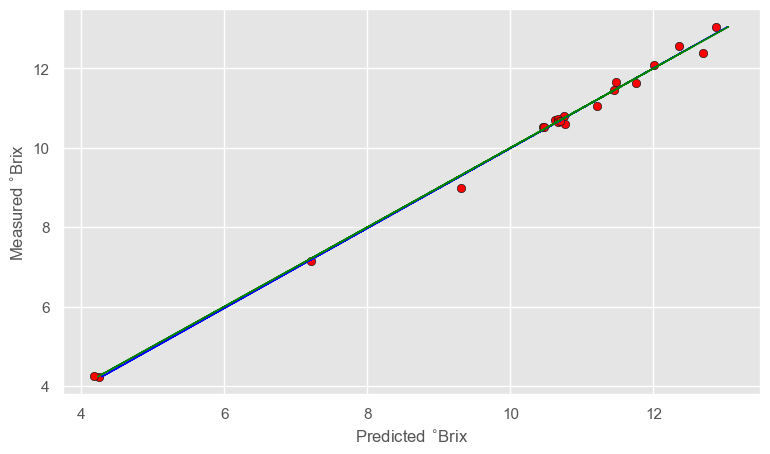

INFO Model loss : 0.020466636753966226
INFO Elapsed time for pipeline run : 2.03
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : data/beer_dataset.csv , Preprocessor : savgol0+snv, Model : pls, Evaluator : mse, Validation type : stratified-kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 

INFO Optimized n_comp for PLS 3
INFO [MODEL EVALUATION]




[Model Evaluation] MSE value between y_test and y_pred : 0.020


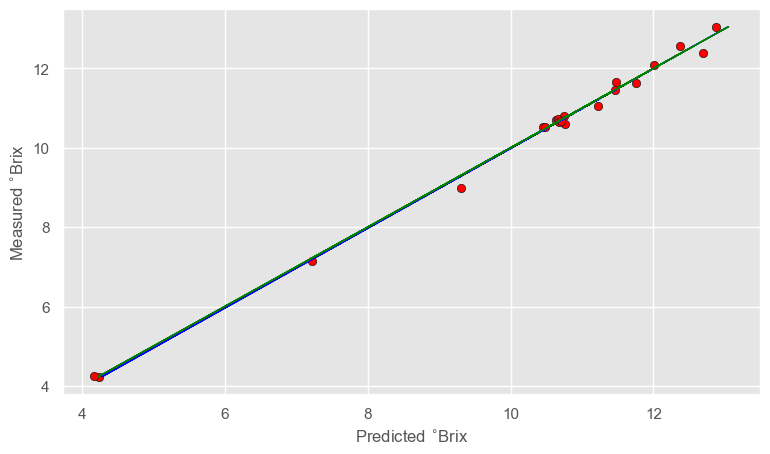

INFO Model loss : 0.020490626226427486
INFO Elapsed time for pipeline run : 2.33
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : data/beer_dataset.csv , Preprocessor : savgol1+snv, Model : pls, Evaluator : mse, Validation type : stratified-kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 


INFO Optimized n_comp for PLS 2
INFO [MODEL EVALUATION]



[Model Evaluation] MSE value between y_test and y_pred : 4.065


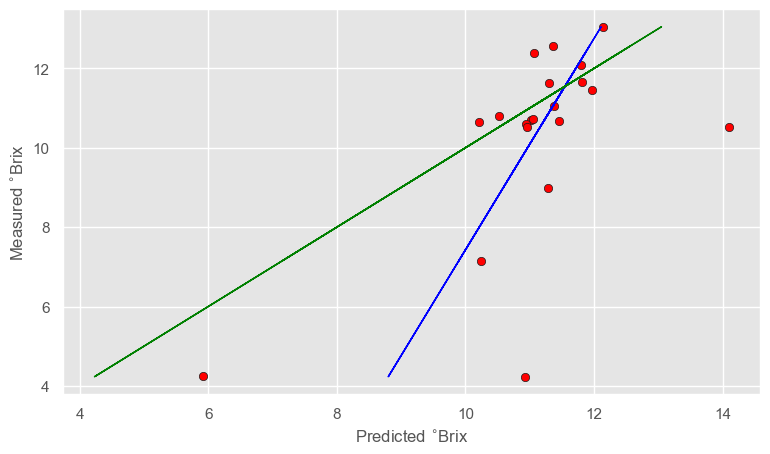

INFO Model loss : 4.065244750029648
INFO Elapsed time for pipeline run : 2.33
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : data/beer_dataset.csv , Preprocessor : savgol2+snv, Model : pls, Evaluator : mse, Validation type : stratified-kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 

INFO Optimized n_comp for PLS 4
INFO [MODEL EVALUATION]




[Model Evaluation] MSE value between y_test and y_pred : 2.007


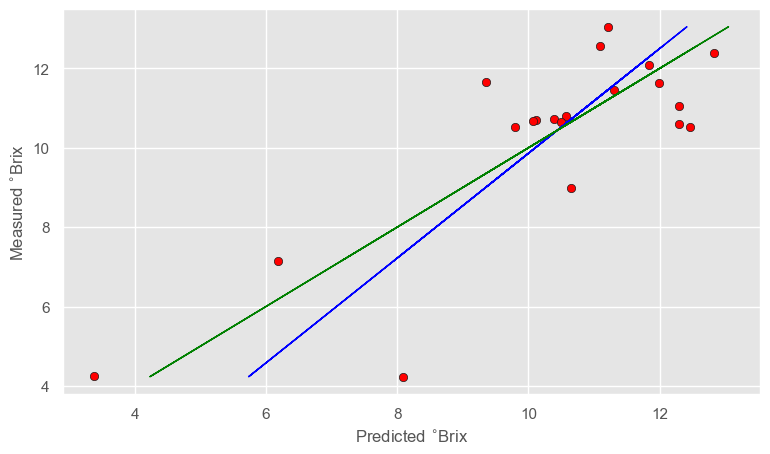

INFO Model loss : 2.007221330632688
INFO Elapsed time for pipeline run : 2.64
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : data/beer_dataset.csv , Preprocessor : savgol0+msc, Model : pls, Evaluator : mse, Validation type : stratified-kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 

INFO Optimized n_comp for PLS 3
INFO [MODEL EVALUATION]




[Model Evaluation] MSE value between y_test and y_pred : 0.020


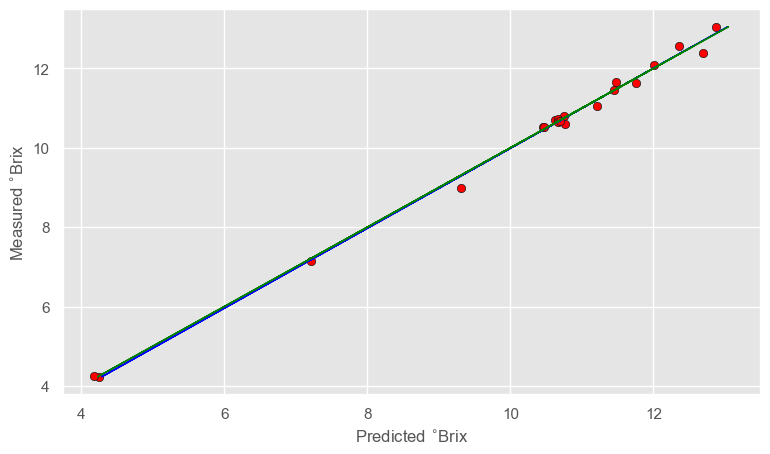

INFO Model loss : 0.02046663675396027
INFO Elapsed time for pipeline run : 2.71
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : data/beer_dataset.csv , Preprocessor : savgol1+msc, Model : pls, Evaluator : mse, Validation type : stratified-kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 

INFO Optimized n_comp for PLS 1
INFO [MODEL EVALUATION]




[Model Evaluation] MSE value between y_test and y_pred : 8.041


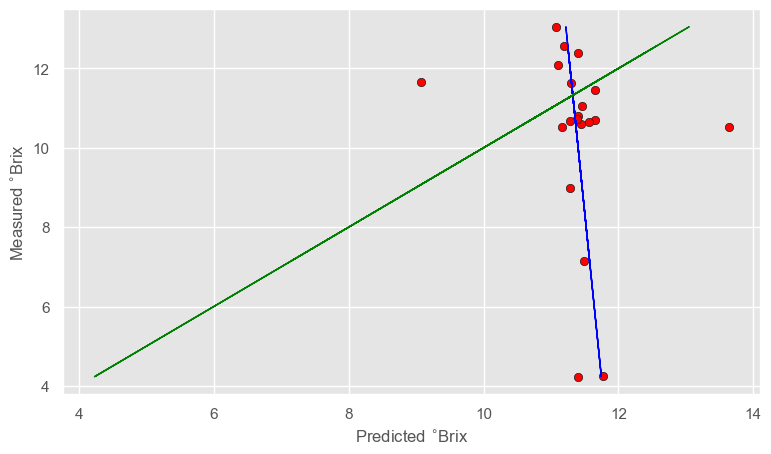

INFO Model loss : 8.041428273748638
INFO Elapsed time for pipeline run : 2.35
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : data/beer_dataset.csv , Preprocessor : savgol2+msc, Model : pls, Evaluator : mse, Validation type : stratified-kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 

INFO Optimized n_comp for PLS 1
INFO [MODEL EVALUATION]




[Model Evaluation] MSE value between y_test and y_pred : 6.806


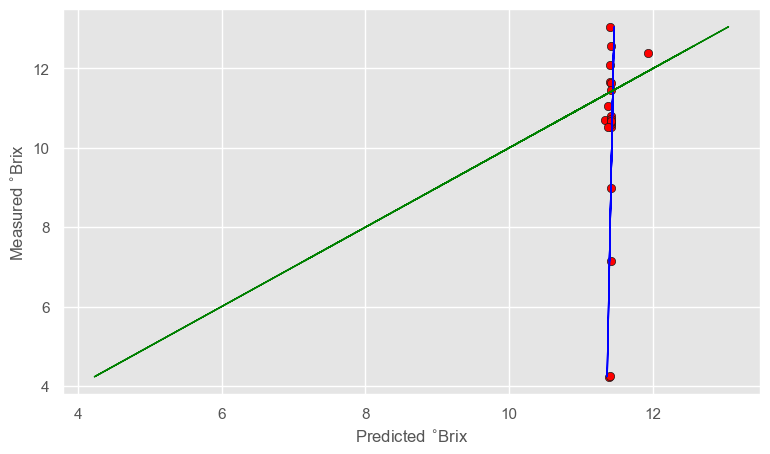

INFO Model loss : 6.805821048614066
INFO Elapsed time for pipeline run : 2.42
INFO Pipeline end...
INFO ************************************


In [11]:
# Data splitting can be done in various proportions. Check proportions of train-test values available in configfile.ini file
data = (X_train, X_test, y_train, y_test) = util.get_split_data(files=dataset, split_params=split_params, test_size=float(split_size[2]), showDataEDA=False)

# Run pipeline in loop for all preprocessors combinations OR
# For selected preprocessors only, you can run the loop using a slice from the whole preprocessors list variable.
# To check which slice you want, check the configfile.ini file
for index, val in enumerate(preprocessors):
    if index in [0, 5, 8]:
        derivative = 0
    elif index in [1, 6, 9]:
        derivative = 1
    elif index in [2, 7, 10]:
        derivative = 2

    # Ideally not required to change anything here.
    # But you can change the derivative explicitly as per your choice (0,1 or 2)
    preprocessor_params = {
        'savgol' : {
            'window_size_range' : np.arange(3,63,3),
            'polyorder_range' : np.arange(2,18,2),
            'derivative' : derivative
        }
    }

    # Set plotting:True for showing all plots (preprocessing, model fitting, etc. everything)
    # Set showModelEvaluationPlots:True specifically to show final model evaluation and line of best fit plots. IDEALLY MUST BE SET TO True
    # Set models[0] for PLS and models[1] for LASSO
    # evaluators[0] means MSE. Nothing to change here because MSE is best for regression model evaluation
    # preprocessor: preprocessor[index] where index is (0,...,10). Here since it's running in loop, it gets from val.
    # preprocessor-params: only required for SavGol and its related combos.
    # pipeline_run_type: pipeline_run_types[index] -> index can be 0 or 1. 0 means only until preprocessing, 1 means total.
    pipeline_params = {
        'logger' : logger,
        'data' : data,
        'validation-type' : validation_types[1],
        'preprocessor' : val,
        'preprocessor-params' : preprocessor_params,
        'model' : models[0],
        'evaluator' : evaluators[0],
        'pls_max_n_comp' : int(pls_max_n_comp),
        'folds' : int(folds),
        'wl' : wl,
        'plotting' : False,
        'showModelEvaluationPlots' : True,
        'pipeline_run_type' : pipeline_run_types[1]
    }

    start = timer()
    logger.info("Pipeline Start...")
    logger.info("Parameters :")
    params = "Data : " + str(dataset) + " , Preprocessor : " + str(pipeline_params['preprocessor']) + ", Model : " + str(pipeline_params['model']) + ", Evaluator : " + str(pipeline_params['evaluator']) + ", Validation type : " + str(pipeline_params['validation-type']) + ", PLS max n_comp : " + str(pipeline_params['pls_max_n_comp']) + ", folds (for CV) : " + str(pipeline_params['folds'])
    logger.info(params)
    util.pipeline(pipeline_params)
    end = timer()
    logger.info("Elapsed time for pipeline run : " + str(round((end - start),2)))
    logger.info("Pipeline end...")
    logger.info("************************************")


<h3 style="color: #00faaa">PIPELINE 3 [Scatter Correction only]</h3>
<h5 style="color: white">Preprocessor - SNV & MSC</h5>
<h5 style="color: white">Train/Test split size (FIXED) - 80/20</h5>
<h5 style="color: white">Validation method (FIXED) - KFolds CV, folds=5</h5>

In [13]:
# Run pipeline in loop for all preprocessors combinations OR
# For selected preprocessors only, you can run the loop using a slice from the whole preprocessors list variable.
# To check which slice you want, check the configfile.ini file
for index, val in enumerate(preprocessors):
    if index in [3, 4]:

        # Ideally not required to change anything here.
        # But you can change the derivative explicitly as per your choice (0,1 or 2)
        preprocessor_params = {

        }

        # Set plotting:True for showing all plots (preprocessing, model fitting, etc. everything)
        # Set showModelEvaluationPlots:True specifically to show final model evaluation and line of best fit plots. IDEALLY MUST BE SET TO True
        # Set models[0] for PLS and models[1] for LASSO
        # evaluators[0] means MSE. Nothing to change here because MSE is best for regression model evaluation
        # preprocessor: preprocessor[index] where index is (0,...,10). Here since it's running in loop, it gets from val.
        # preprocessor-params: only required for SavGol and its related combos.
        # pipeline_run_type: pipeline_run_types[index] -> index can be 0 or 1. 0 means only until preprocessing, 1 means total.
        pipeline_params = {
            'logger' : logger,
            'data' : data,
            'validation-type' : validation_types[0],
            'preprocessor' : val,
            'preprocessor-params' : preprocessor_params,
            'model' : models[0],
            'evaluator' : evaluators[0],
            'pls_max_n_comp' : int(pls_max_n_comp),
            'folds' : int(folds),
            'wl' : wl,
            'plotting' : False,
            'showModelEvaluationPlots' : True,
            'pipeline_run_type' : pipeline_run_types[0]
        }

        start = timer()
        logger.info("Pipeline Start...")
        logger.info("Parameters :")
        params = "Data : " + str(dataset) + " , Preprocessor : " + str(pipeline_params['preprocessor']) + ", Model : " + str(pipeline_params['model']) + ", Evaluator : " + str(pipeline_params['evaluator']) + ", Validation type : " + str(pipeline_params['validation-type']) + ", PLS max n_comp : " + str(pipeline_params['pls_max_n_comp']) + ", folds (for CV) : " + str(pipeline_params['folds'])
        logger.info(params)
        util.pipeline(pipeline_params)
        end = timer()
        logger.info("Elapsed time for pipeline run : " + str(round((end - start),2)))
        logger.info("Pipeline end...")
        logger.info("************************************")


INFO Pipeline Start...
INFO Parameters :
INFO Data : data/beer_dataset.csv , Preprocessor : snv, Model : pls, Evaluator : mse, Validation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO Elapsed time for pipeline run : 0.01
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : data/beer_dataset.csv , Preprocessor : msc, Model : pls, Evaluator : mse, Validation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO Elapsed time for pipeline run : 0.01
INFO Pipeline end...
INFO ************************************
